## Test the repo output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

In [1]:
# # plt.imshow()
# !pip install flow_vis

In [3]:
import numpy as np
flow_file = '/home/yoyee/Documents/deep_keyframe/pytorch-pwc/flow.out.npy'
flow = np.load(flow_file)

In [4]:

flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=False)

In [5]:
flow_color.shape

(436, 1024, 3)

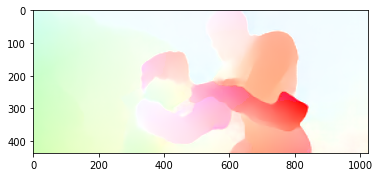

In [6]:

plt.imshow(flow_color)
plt.show()

## Test pwcNet

In [3]:
import numpy as np
from pwcNet import estimate, estimate_batch
import torch
import PIL
import PIL.Image

In [4]:
dummy_im = np.ones((120,160,3))
first_file = './images/first.png'
second_file = './images/second.png'
first_im = np.array(PIL.Image.open(first_file))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
second_im = np.array(PIL.Image.open(second_file))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
# tenFirst = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
tenFirst = torch.FloatTensor(first_im)
# tenSecond = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
tenSecond = torch.FloatTensor(second_im)
flow = estimate(tenFirst, tenSecond)

In [12]:
# estimate_batch
device = 'cuda'
flow = estimate_batch(tenFirst.unsqueeze(0).to(device), tenSecond.unsqueeze(0).to(device))
print(flow.shape)
flow = flow.to('cpu').squeeze(0).numpy().transpose([1,2,0])
print(flow.shape)

torch.Size([1, 2, 436, 1024])
(436, 1024, 2)


In [24]:
# estimate_batch repetitive images
first_im = np.array(PIL.Image.open(first_file)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
tenFirst = torch.FloatTensor(first_im)
tenFirst = torch.stack([tenFirst]*2)
second_im = np.array(PIL.Image.open(second_file)).transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
tenSecond = torch.FloatTensor(second_im)
tenSecond = torch.stack([tenSecond]*2)
print(f"tenFirst: {tenFirst.shape}")

flow = estimate_batch(tenFirst.to(device), tenSecond.to(device))
flow = flow.to('cpu').numpy().transpose([0,2,3,1])
print(flow.shape)

tenFirst: torch.Size([2, 3, 436, 1024])
tenPreprocessedFirst: torch.Size([2, 3, 448, 1024])
(2, 436, 1024, 2)


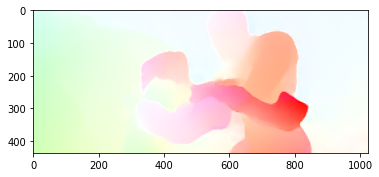

In [26]:
flow_color = flow_vis.flow_to_color(flow[1], convert_to_bgr=False)
plt.imshow(flow_color)
plt.show()